In [23]:
import numpy as np
from mpl_toolkits import mplot3d
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl
from numpy import arange,array,ones,linalg
from scipy.optimize import minimize
from scipy import stats

from astropy.io import fits
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
import math

from scipy.ndimage import gaussian_filter1d


# for classifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from joblib import dump, load

In [24]:
SGA = Table.read('SGA_Color_Params.fits')
SGA

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,COLOR G-Z,COLOR G-R,COLOR R-Z,R50_R,m(r50)_G,m(r50)_Z,m(r50)_R,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_G_r50_r90,C_INDEX_R_r50_r90,C_INDEX_Z_r50_r90,r90_R,r50_G,r90_G,r50_Z,r90_Z
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.29782

## T-type classification

In [25]:
# Look at morph types in SGA
unique, counts = np.unique(SGA['MORPHTYPE'], return_counts = True)
print(unique, counts)

MORPHTYPE
---------
         
  .E+..?.
  .E+..P*
  .E+4...
  .E...P*
  .I..9P.
  .IBS9..
  .L..+P*
  .L?....
  .LXS-*.
      ...
      Sab
       Sb
      Sbc
       Sc
      Scd
       Sd
       Sm
     dIrr
dIrr/dSph
     dSph
    dSph?
Length = 65 rows [     3      1      3      1      1      1      2      1      1      1
      1      1      1      2      1      1      1      1      1      1
     35   1320      1   1117      1      5  45468   3251  11137     26
   2374    118    270      1 169164    419      2   4749  14527  39252
    330    771    804    141    129    957   1492   3463   3763   3473
    783    499    459   2887   5990  11076  17294  28455   3382   2470
   1712     15      6      5      1]


In [26]:
SGA.add_column(np.nan, name='T_TYPE')

# Elliptical and dwarf ellipticals
# 45468 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'E'] = -5

# Lenticulars
# 4749
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'S0'] = -2
#14527
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'S0-a'] = 0


# Spirals
# 2887 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sa'] = 1

# 5990
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sab'] = 2

# 11076 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sb'] = 3

#17294 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sbc'] = 4

#28455 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sc'] = 5

#3382
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Scd'] = 6

#2470 
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sd'] = 7

# Irregulars
#1712 + 16 + 270 + 2734 + 118
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Sm'] = 9
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'Irr'] = 10
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'dIrr'] = 10
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'I'] = 10

# Dwarf spheroidal (5)
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'dSph'] = 11

# To group barred spirals and spirals for classifier (assigned them SAB = 0.5 and SB = 100, IAB = 10.5, IB = 1000)

In [27]:
#Barred spirals
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SABa'] = 0.5
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SBa'] = 100

SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SBab'] = 100

SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SABb'] = 0.5
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SBb'] = 100

SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SBbc'] = 100

SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SABc'] = 0.5
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SBc'] = 100

SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SBcd'] = 100

SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SABd'] = 0.5
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'SBd'] = 100

# Barred irregulars
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'IB'] = 1000
SGA['T_TYPE'][SGA['MORPHTYPE'] == 'IAB'] = 10.5

In [28]:
SGA.sort('T_TYPE')
#Get color and morph parameters on new table for random forest 
Relevant = Table([SGA['MORPHTYPE'], SGA['T_TYPE'], SGA['GRADIENT_G-Z'], SGA['GRADIENT_G-R'], SGA['GRADIENT_R-Z'], 
                 SGA['C_INDEX_R_r50_r90'], SGA['COLOR G-Z'], SGA['COLOR G-R'], SGA['COLOR R-Z']])
Relevant

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z
bytes21,float64,float32,float32,float32,float32,float32,float32,float32
E,-5.0,-0.08053315,-0.039860122,-0.040673025,0.2654967,1.5669317,0.92661285,0.6403189
E,-5.0,-0.40387142,0.004846856,-0.40871826,0.27546477,1.4367275,0.8673582,0.5693693
E,-5.0,-0.123693734,-0.08581622,-0.037877515,0.15428518,1.4519243,0.822361,0.62956333
E,-5.0,-0.1567286,-0.0832728,-0.073455796,0.17373967,1.4834995,0.8631449,0.62035465
E,-5.0,--,--,--,--,--,--,--
E,-5.0,--,--,--,--,--,--,--
E,-5.0,-0.36010554,-0.10177859,-0.25832695,0.2471635,0.502121,0.35577965,0.14634132
E,-5.0,-0.57374096,-0.2703109,-0.30343002,0.26934788,1.5422955,0.93822193,0.6040735
E,-5.0,-0.39048073,-0.051522456,-0.33895826,0.23630454,1.3482027,0.88240147,0.46580124


In [29]:
# Group by ellipticals, spirals, lenticulars and irregulars (no barred galaxies)
Relevant.add_column('Undefined', name='TYPE')

spirals = [1, 2, 3, 4, 5, 6, 7]
for i in spirals:
    Relevant['TYPE'][Relevant['T_TYPE'] == i] = 'Spirals'

Relevant['TYPE'][Relevant['T_TYPE'] == -5] = 'Elliptic'

Relevant['TYPE'][Relevant['T_TYPE'] == -2] = 'Len'
Relevant['TYPE'][Relevant['T_TYPE'] == 0] = 'Len'

Relevant['TYPE'][Relevant['T_TYPE'] == 9] = 'Irregular'
Relevant['TYPE'][Relevant['T_TYPE'] == 10] = 'Irregular'
Relevant

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
E,-5.0,-0.08053315,-0.039860122,-0.040673025,0.2654967,1.5669317,0.92661285,0.6403189,Elliptic
E,-5.0,-0.40387142,0.004846856,-0.40871826,0.27546477,1.4367275,0.8673582,0.5693693,Elliptic
E,-5.0,-0.123693734,-0.08581622,-0.037877515,0.15428518,1.4519243,0.822361,0.62956333,Elliptic
E,-5.0,-0.1567286,-0.0832728,-0.073455796,0.17373967,1.4834995,0.8631449,0.62035465,Elliptic
E,-5.0,--,--,--,--,--,--,--,Elliptic
E,-5.0,--,--,--,--,--,--,--,Elliptic
E,-5.0,-0.36010554,-0.10177859,-0.25832695,0.2471635,0.502121,0.35577965,0.14634132,Elliptic
E,-5.0,-0.57374096,-0.2703109,-0.30343002,0.26934788,1.5422955,0.93822193,0.6040735,Elliptic
E,-5.0,-0.39048073,-0.051522456,-0.33895826,0.23630454,1.3482027,0.88240147,0.46580124,Elliptic


In [30]:
Relevant[Relevant['TYPE'] == 'Undefined']

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
SABb,0.5,--,--,--,0.042772025,0.9967184,0.5958929,0.4008255,Undefined
SABc,0.5,-0.19883502,-0.10914318,-0.08969183,0.42260286,1.1245508,0.6339741,0.49057674,Undefined
SABb,0.5,0.07041341,-0.09049877,0.16091219,0.6442315,1.4632177,0.83658695,0.6266308,Undefined
SABb,0.5,-0.633145,-0.15404965,-0.47909534,0.3240192,1.1127119,0.7560892,0.3566227,Undefined
SABb,0.5,-0.036345154,0.024835736,-0.06118089,0.22715889,0.97081757,0.57158756,0.39923,Undefined
SABa,0.5,-0.108963326,-0.0109358225,-0.0980275,0.4287762,1.4003725,0.77643013,0.6239424,Undefined
SABc,0.5,-0.7151351,-0.11226666,-0.60286844,0.34504166,0.71023464,0.60486317,0.105371475,Undefined
SABc,0.5,-0.09375684,-0.037890688,-0.055866152,0.4017424,1.1955328,0.6710167,0.5245161,Undefined
SABa,0.5,-0.36452103,-0.19767682,-0.16684419,0.3769835,1.1467447,0.6542053,0.4925394,Undefined


In [31]:
#Remove all rows with undefined morph type
Relevant.sort('TYPE')
Relevant.remove_rows([range(140400,383620)])
Relevant

/global/common/software/desi/perlmutter/desiconda/20230111-2.1.0/conda/lib/python3.10/site-packages/astropy/table/table.py:2750: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  keep_mask[row_specifier] = False


MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
E,-5.0,-0.08053315,-0.039860122,-0.040673025,0.2654967,1.5669317,0.92661285,0.6403189,Elliptic
E,-5.0,-0.094928086,-0.044380188,-0.050547898,0.10621755,1.7995405,1.0405664,0.7589741,Elliptic
E,-5.0,-0.074849755,-0.04052031,-0.034329444,0.33767715,1.7317305,1.0054932,0.7262373,Elliptic
E,-5.0,-0.07492235,-0.041893303,-0.03302905,0.22825861,1.6452312,0.94165134,0.7035799,Elliptic
E,-5.0,--,--,--,--,--,--,--,Elliptic
E,-5.0,-0.05123826,-0.059383307,0.0081450455,0.45105666,0.7318125,0.44948578,0.2823267,Elliptic
E,-5.0,-0.18065003,-0.27224275,0.091592744,0.3519871,1.4474115,0.896081,0.55133057,Elliptic
E,-5.0,-0.08530855,-0.051298857,-0.034009695,0.2623697,1.9316826,1.1714153,0.76026726,Elliptic
E,-5.0,-0.893085,-0.106452405,-0.7866326,0.11672604,1.3453112,0.9524956,0.3928156,Elliptic


In [32]:
filtering_for_classifier = np.logical_not(Relevant['GRADIENT_G-Z'].mask)& np.logical_not(Relevant['GRADIENT_G-R'].mask)& np.logical_not(Relevant['GRADIENT_R-Z'].mask) & np.logical_not(Relevant['C_INDEX_R_r50_r90'].mask)& np.logical_not(Relevant['COLOR G-Z'].mask) & np.logical_not(Relevant['COLOR G-R'].mask)& np.logical_not(Relevant['COLOR R-Z'].mask)
Data = Relevant[filtering_for_classifier]
Data

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
E,-5.0,-0.08053315,-0.039860122,-0.040673025,0.2654967,1.5669317,0.92661285,0.6403189,Elliptic
E,-5.0,-0.094928086,-0.044380188,-0.050547898,0.10621755,1.7995405,1.0405664,0.7589741,Elliptic
E,-5.0,-0.074849755,-0.04052031,-0.034329444,0.33767715,1.7317305,1.0054932,0.7262373,Elliptic
E,-5.0,-0.07492235,-0.041893303,-0.03302905,0.22825861,1.6452312,0.94165134,0.7035799,Elliptic
E,-5.0,-0.05123826,-0.059383307,0.0081450455,0.45105666,0.7318125,0.44948578,0.2823267,Elliptic
E,-5.0,-0.18065003,-0.27224275,0.091592744,0.3519871,1.4474115,0.896081,0.55133057,Elliptic
E,-5.0,-0.08530855,-0.051298857,-0.034009695,0.2623697,1.9316826,1.1714153,0.76026726,Elliptic
E,-5.0,-0.893085,-0.106452405,-0.7866326,0.11672604,1.3453112,0.9524956,0.3928156,Elliptic
E,-5.0,-0.1221613,-0.07958071,-0.042580582,0.22963335,1.4986792,0.8752842,0.62339497,Elliptic


In [33]:
unique, counts = np.unique(Data['TYPE'], return_counts = True)
print(unique, counts)

   TYPE  
---------
 Elliptic
Irregular
      Len
  Spirals [41879  3697 18019 67621]


In [34]:
# Get equal samples for all general types of galaxies, in this case take min. value of 3975 for each
sample_elliptical = Data[Data['TYPE'] == 'Elliptic'][:3697]
sample_lenticular = Data[Data['TYPE'] == 'Len'][:3697]
sample_spirals = Data[Data['TYPE'] == 'Spirals'][:3697]
sample_irregular = Data[Data['TYPE'] == 'Irregular']
new_data = vstack([sample_elliptical, sample_lenticular, sample_spirals, sample_irregular])
new_data

MORPHTYPE,T_TYPE,GRADIENT_G-Z,GRADIENT_G-R,GRADIENT_R-Z,C_INDEX_R_r50_r90,COLOR G-Z,COLOR G-R,COLOR R-Z,TYPE
bytes21,float64,float32,float32,float32,float32,float32,float32,float32,str9
E,-5.0,-0.08053315,-0.039860122,-0.040673025,0.2654967,1.5669317,0.92661285,0.6403189,Elliptic
E,-5.0,-0.094928086,-0.044380188,-0.050547898,0.10621755,1.7995405,1.0405664,0.7589741,Elliptic
E,-5.0,-0.074849755,-0.04052031,-0.034329444,0.33767715,1.7317305,1.0054932,0.7262373,Elliptic
E,-5.0,-0.07492235,-0.041893303,-0.03302905,0.22825861,1.6452312,0.94165134,0.7035799,Elliptic
E,-5.0,-0.05123826,-0.059383307,0.0081450455,0.45105666,0.7318125,0.44948578,0.2823267,Elliptic
E,-5.0,-0.18065003,-0.27224275,0.091592744,0.3519871,1.4474115,0.896081,0.55133057,Elliptic
E,-5.0,-0.08530855,-0.051298857,-0.034009695,0.2623697,1.9316826,1.1714153,0.76026726,Elliptic
E,-5.0,-0.893085,-0.106452405,-0.7866326,0.11672604,1.3453112,0.9524956,0.3928156,Elliptic
E,-5.0,-0.1221613,-0.07958071,-0.042580582,0.22963335,1.4986792,0.8752842,0.62339497,Elliptic


In [35]:
unique, counts = np.unique(new_data['TYPE'], return_counts = True)
print(unique, counts)

   TYPE  
---------
 Elliptic
Irregular
      Len
  Spirals [3697 3697 3697 3697]


## Random forest (with barred galaxies as their respective spiral categories)

In [36]:
# Determine the correct shapes of the array
N = len(new_data)
X = np.zeros((N,7)) 

# Basically copying columns to associate later
X[:,0]= new_data['GRADIENT_G-Z']
X[:,1]= new_data['GRADIENT_G-R']
X[:,2]= new_data['GRADIENT_R-Z']
X[:,3]= new_data['C_INDEX_R_r50_r90']
X[:,4]= new_data['COLOR G-Z']
X[:,5]= new_data['COLOR G-R']
X[:,6]= new_data['COLOR R-Z']

# Target data array
y = np.array(new_data['TYPE'])
print(X.size, y.size)

103516 14788


In [37]:
# Train and test data samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train.shape, X_test.shape

((10351, 7), (4437, 7))

In [38]:
y_train.shape, y_test.shape

((10351,), (4437,))

In [39]:
# create random forest
random_forest_100 = RandomForestClassifier(n_estimators=100, random_state=42)

# fit the model to the training set
classification_fit = random_forest_100.fit(X_train, y_train)

# Predict on the test set results
y_pred = random_forest_100.predict(X_test)

# Check accuracy score 
print('Model accuracy score with 100 decision trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
accuracy = accuracy_score(y_test, y_pred,normalize=False)
print('Correctly classified points =', accuracy)

Model accuracy score with 100 decision trees : 0.6644
Correctly classified points = 2948


In [40]:
# Evaluate the classifier
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

    Elliptic       0.67      0.62      0.65      1119
   Irregular       0.76      0.72      0.74      1066
         Len       0.56      0.61      0.59      1110
     Spirals       0.68      0.70      0.69      1142

    accuracy                           0.66      4437
   macro avg       0.67      0.66      0.67      4437
weighted avg       0.67      0.66      0.67      4437



In [41]:
feature_scores = random_forest_100.feature_importances_
feature_scores

array([0.10269715, 0.1245701 , 0.10072269, 0.17031328, 0.16448811,
       0.18762432, 0.14958435])

In [42]:
feature_scores = random_forest_100.feature_importances_

# from values
#X[:,0]= Data['GRADIENT_G-Z']
#X[:,1]= Data['GRADIENT_G-R']
#X[:,2]= Data['GRADIENT_R-Z']
#X[:,3]= Data['C_INDEX_R_r50_r90']
#X[:,4]= Data['COLOR G-Z']
#X[:,5]= Data['COLOR G-R']
#X[:,6]= Data['COLOR R-Z']

array = np.array([['Gradient_G-Z', 0.10269715], ['Gradient_G-R', 0.1245701], 
                  ['Gradient_R_Z', 0.10072269], ['C_INDEX_R_r50_r90', 0.17031328],  
                  ['COLOR G-Z', 0.16448811], ['COLOR G-R', 0.18762432], ['COLOR R-Z', 0.14958435]]) 

column_values = ['Parameters', 'Feature_Scores'] 

index_values = [1, 2, 3, 4, 5, 6, 7] 

Feature_scores = pd.DataFrame(data = array,  
                  index = index_values,  
                  columns = column_values) 
  
# displaying the dataframe 
Feature_scores.sort_values(by=['Feature_Scores'], ascending=False)

,Parameters,Feature_Scores
6,COLOR G-R,0.18762432
4,C_INDEX_R_r50_r90,0.17031328
5,COLOR G-Z,0.16448811
7,COLOR R-Z,0.14958435
2,Gradient_G-R,0.1245701
1,Gradient_G-Z,0.10269715
3,Gradient_R_Z,0.10072269


## Confusion matrix

In [44]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[695  46 319  59]
 [ 24 772  64 206]
 [288  24 677 121]
 [ 25 169 144 804]]


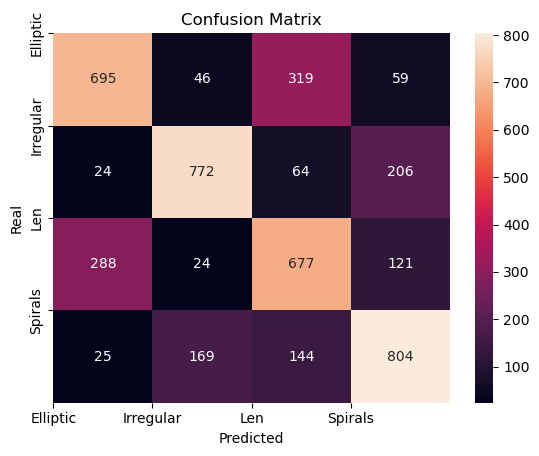

In [45]:
# Visualizing confusion matrix
sns.heatmap(cm, annot=True, fmt="d")

plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.xticks(np.arange(len(np.unique(y))), np.unique(y))
plt.yticks(np.arange(len(np.unique(y))), np.unique(y))

plt.show()